# Homework 4: Factor Important

C111156103, 潘奕濬

## 環境設定

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Import data from UCI machine learning repository

In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
assert mushroom.data is not None
assert isinstance(mushroom.data.features, pd.DataFrame)
assert isinstance(mushroom.data.targets, pd.DataFrame)

X = mushroom.data.features
y = mushroom.data.targets

## 缺失值處理 - missing values

In [4]:
# Check missing values
missing_values = X.isnull().sum()
print("特徵缺失值：")
print(missing_values)

missing_values_y = y.isnull().sum()
print("\n目標變數缺失值：")
print(missing_values_y)

特徵缺失值：
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

目標變數缺失值：
poisonous    0
dtype: int64


很明顯 stalk-root 有一個缺失值。查看缺失值相對於所有值的比例。

In [5]:
missing_ratio = X.isnull().sum().sum() / X.shape[0]
print(f"缺失值比例：{missing_ratio:.2%}")

缺失值比例：30.53%


居然有 30%！要不就刪除這一個 column 好了 …

In [6]:
# drop 'stalk-root' column and meaningless column
Xc = X.drop(columns=['stalk-root', 'veil-type'])

## Label 分類數值

### 各特徵的唯一值數量及其項目

In [7]:
# 各特徵的唯一值數量及其項目
for _col in Xc.columns:
    print(f"\n{_col}: {Xc[_col].nunique()} 個唯一值")
    print(Xc[_col].value_counts())

# 建立一個包含每個特徵的唯一值數量和項目的DataFrame
features_info = []
for _col in Xc.columns:
    _unique_values = Xc[_col].unique().tolist()
    features_info.append({
        'feature': _col,
        'unique_count': Xc[_col].nunique(),
        'values': _unique_values
    })

features_info_df = pd.DataFrame(features_info)
features_info_df


cap-shape: 6 個唯一值
cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64

cap-surface: 4 個唯一值
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64

cap-color: 10 個唯一值
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64

bruises: 2 個唯一值
bruises
f    4748
t    3376
Name: count, dtype: int64

odor: 9 個唯一值
odor
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64

gill-attachment: 2 個唯一值
gill-attachment
f    7914
a     210
Name: count, dtype: int64

gill-spacing: 2 個唯一值
gill-spacing
c    6812
w    1312
Name: count, dtype: int64

gill-size: 2 個唯一值
gill-size
b    5612
n    2512
Name: count, dtype: int64

gill-color: 12 個唯一值
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: count, dtype: int64

st

feature  unique_count  \
0                  cap-shape             6   
1                cap-surface             4   
2                  cap-color            10   
3                    bruises             2   
4                       odor             9   
5            gill-attachment             2   
6               gill-spacing             2   
7                  gill-size             2   
8                 gill-color            12   
9                stalk-shape             2   
10  stalk-surface-above-ring             4   
11  stalk-surface-below-ring             4   
12    stalk-color-above-ring             9   
13    stalk-color-below-ring             9   
14                veil-color             4   
15               ring-number             3   
16                 ring-type             5   
17         spore-print-color             9   
18                population             6   
19                   habitat             7   

                                  values  
0                     [x, b, s, f, k, c]  
1                           [s, y, f, g]  
2         [n, y, w, g, e, p, b, u, c, r]  
3                                 [t, f]  
4            [p, a, l, n, f, c, y, s, m]  
5                                 [f, a]  
6                                 [c, w]  
7                                 [n, b]  
8   [k, n, g, p, w, h, u, e, b, r, y, o]  
9                                 [e, t]  
10                          [s, f, k, y]  
11                          [s, f, y, k]  
12           [w, g, p, n, b, e, o, c, y]  
13           [w, p, g, b, n, e, y, o, c]  
14                          [w, n, o, y]  
15                             [o, t, n]  
16                       [p, e, l, f, n]  
17           [k, n, u, h, w, r, o, y, b]  
18                    [s, n, a, v, y, c]  
19                 [u, g, m, d, p, w, l]

### 針對 Binary 資料使用 label encoder

In [8]:
Xc_encoded_part1 = Xc.copy()

binary_features = features_info_df[features_info_df["unique_count"] <= 2]

le = LabelEncoder()
for col in binary_features["feature"]:
    Xc_encoded_part1[col] = le.fit_transform(Xc_encoded_part1[col])

### 針對 Non-binary 資料使用 one-hot encoder

In [9]:
onehot_features = features_info_df[features_info_df["unique_count"] > 2]

Xc_encoded = pd.get_dummies(Xc_encoded_part1, columns=onehot_features["feature"], dtype='int64')
Xc_encoded

bruises  gill-attachment  gill-spacing  gill-size  stalk-shape  \
0           1                1             0          1            0   
1           1                1             0          0            0   
2           1                1             0          0            0   
3           1                1             0          1            0   
4           0                1             1          0            1   
...       ...              ...           ...        ...          ...   
8119        0                0             0          0            0   
8120        0                0             0          0            0   
8121        0                0             0          0            0   
8122        0                1             0          1            1   
8123        0                0             0          0            0   

      cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  ...  \
0               0            0            0            0            0  ...   
1               0            0            0            0            0  ...   
2               1            0            0            0            0  ...   
3               0            0            0            0            0  ...   
4               0            0            0            0            0  ...   
...           ...          ...          ...          ...          ...  ...   
8119            0            0            0            1            0  ...   
8120            0            0            0            0            0  ...   
8121            0            0            1            0            0  ...   
8122            0            0            0            1            0  ...   
8123            0            0            0            0            0  ...   

      population_s  population_v  population_y  habitat_d  habitat_g  \
0                1             0             0          0          0   
1                0             0             0          0          1   
2                0             0             0          0          0   
3                1             0             0          0          0   
4                0             0             0          0          1   
...            ...           ...           ...        ...        ...   
8119             0             0             0          0          0   
8120             0             1             0          0          0   
8121             0             0             0          0          0   
8122             0             1             0          0          0   
8123             0             0             0          0          0   

      habitat_l  habitat_m  habitat_p  habitat_u  habitat_w  
0             0          0          0          1          0  
1             0          0          0          0          0  
2             0          1          0          0          0  
3             0          0          0          1          0  
4             0          0          0          0          0  
...         ...        ...        ...        ...        ...  
8119          1          0          0          0          0  
8120          1          0          0          0          0  
8121          1          0          0          0          0  
8122          1          0          0          0          0  
8123          1          0          0          0          0  

[8124 rows x 106 columns]

## 針對目標變數進行 label encoding

In [10]:
# encode y to int
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.to_numpy().ravel())

y_encoded

array([1, 0, 0, ..., 0, 1, 0], shape=(8124,))

## 切割資料集與訓練集

In [11]:
X_train, X_test, y_train, y_test = train_test_split(Xc_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y)

## 使用隨機森林找出重要的特徵

 1) odor_n                         0.138772 selected? True
 2) gill-size                      0.087214 selected? True
 3) odor_f                         0.076237 selected? True
 4) stalk-surface-above-ring_k     0.053815 selected? True
 5) gill-color_b                   0.053612 selected? True
 6) spore-print-color_h            0.046101 selected? True
 7) ring-type_p                    0.039779 selected? True
 8) stalk-surface-below-ring_k     0.035311 selected? True
 9) bruises                        0.031971 selected? True
10) population_v                   0.029576 selected? True
11) ring-type_l                    0.023700 selected? True
12) stalk-surface-above-ring_s     0.023575 selected? True
13) odor_p                         0.022745 selected? True
14) gill-spacing                   0.022029 selected? True
15) spore-print-color_w            0.019074 selected? True
16) stalk-shape                    0.014858 selected? True
17) stalk-surface-below-ring_s     0.013189 selected? Tr

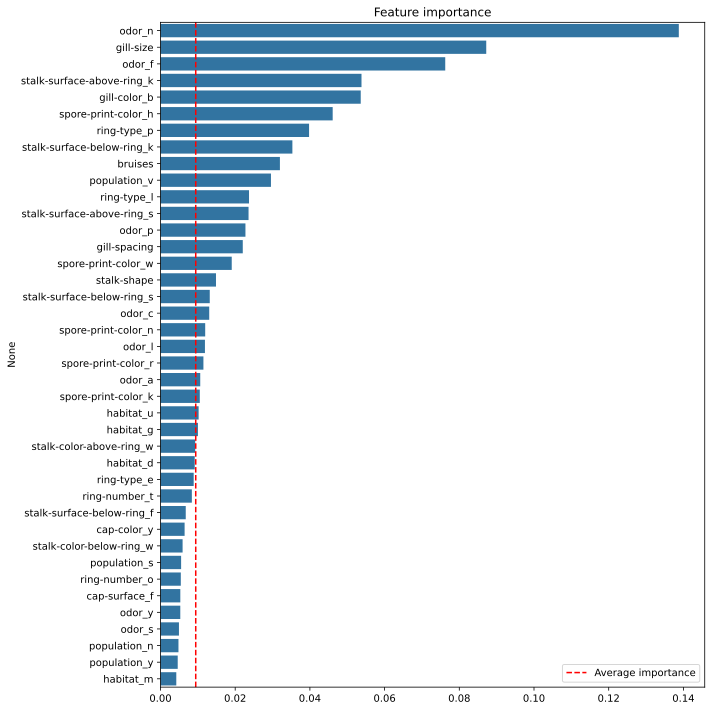

In [12]:
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

assert isinstance(X_train, pd.DataFrame), "X_train is pd.DataFrame"
assert isinstance(X_test, pd.DataFrame), "X_test is pd.DataFrame"
assert isinstance(y_train, np.ndarray), "y_train is np.ndarray"
assert isinstance(y_test, np.ndarray), "y_test is np.ndarray"

feat_labels = Xc_encoded.columns
forest = RandomForestClassifier(n_estimators=500,
                                random_state=42)

forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# 只取前 20 個特徵，以免圖表太長
top_indices = indices[:40]

# average importance
average_importance = np.mean(importances[indices])

for i, f in enumerate(top_indices):
    print("%2d) %-*s %f selected? %s" % (i + 1, 30, 
                            feat_labels[f], 
                            importances[f],
                            importances[f] > average_importance))

plt.figure(figsize=(10, 10))

plt.title('Feature importance')
sns.barplot(x=importances[top_indices], y=feat_labels[top_indices])

# 畫出平均重要性
plt.axvline(x=float(average_importance), color='red', linestyle='--', label='Average importance')
plt.legend()

plt.tight_layout()

plt.show()

根據上面的圖表和表格，我們選前 25 個特徵。

In [13]:
top_25_indices = indices[:25]

print("25 features selected is: ", feat_labels[top_25_indices].to_list())
X_train_selected = X_train[feat_labels[top_25_indices]]
X_test_selected = X_test[feat_labels[top_25_indices]]

25 features selected is:  ['odor_n', 'gill-size', 'odor_f', 'stalk-surface-above-ring_k', 'gill-color_b', 'spore-print-color_h', 'ring-type_p', 'stalk-surface-below-ring_k', 'bruises', 'population_v', 'ring-type_l', 'stalk-surface-above-ring_s', 'odor_p', 'gill-spacing', 'spore-print-color_w', 'stalk-shape', 'stalk-surface-below-ring_s', 'odor_c', 'spore-print-color_n', 'odor_l', 'spore-print-color_r', 'odor_a', 'spore-print-color_k', 'habitat_u', 'habitat_g']


## 使用篩選出的 X 來跑 LR、SVM、KNN 建模

In [14]:
from typing import Callable
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

methods: list[tuple[str, Callable[[], LogisticRegression | SVC | KNeighborsClassifier]]] = [
    ("Logistic Regression", lambda: LogisticRegression(max_iter=1000, random_state=42, n_jobs=8)),
    ("SVM", lambda: SVC(kernel='rbf', random_state=42, gamma="auto", C=10.0)),
    ("KNN", lambda: KNeighborsClassifier(n_neighbors=3, n_jobs=8))
]

In [15]:
# 40 個特徵下去跑
for i, (method_name, construct_method) in enumerate(methods):
    method = construct_method()

    method.fit(X_train_selected, y_train)
    y_pred = method.predict(X_test_selected)
    print(f"{method_name} Accuracy ({len(feat_labels[top_indices])} features selected): {accuracy_score(y_test, y_pred)}")

    # 選擇前兩個最能區分的特徵
    X_train_selected_2d = X_train_selected[feat_labels[top_indices][:2]]

Logistic Regression Accuracy (40 features selected): 0.9963076923076923
SVM Accuracy (40 features selected): 1.0
KNN Accuracy (40 features selected): 1.0


In [16]:
# 只留 2 個特徵以便畫出決策圖
top_2_indices = indices[:2]
X_train_selected_2d = X_train_selected[feat_labels[top_2_indices]]
X_test_selected_2d = X_test_selected[feat_labels[top_2_indices]]

print("2 features selected is: ", feat_labels[top_2_indices].to_list())

2 features selected is:  ['odor_n', 'gill-size']


In [17]:
import warnings
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(20, 15))

# 3x1 的圖表
_, ax = plt.subplots(3, 1)

for i, (method_name, construct_method) in enumerate(methods):
    method = construct_method()

    method.fit(X_train_selected_2d, y_train)
    y_pred = method.predict(X_test_selected_2d)
    print(f"{method_name} Accuracy ({len(feat_labels[top_2_indices])} features selected): {accuracy_score(y_test, y_pred)}")

    # 繪製決策圖 (supresses warning)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        plot_decision_regions(X_train_selected_2d.to_numpy(), y_train, clf=method, ax=ax[i])

    ax[i].set_title(method_name)

plt.tight_layout()
plt.show()

Logistic Regression Accuracy (2 features selected): 0.8855384615384615
SVM Accuracy (2 features selected): 0.8855384615384615
KNN Accuracy (2 features selected): 0.8855384615384615


<Figure size 2000x1500 with 0 Axes>